### Simple derivatives using Chebyshev

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import math as mt
from scipy.linalg import toeplitz

%matplotlib notebook

### 1. Definitions

In [2]:
def GLC_pts(N):
    """
    N+1 Gauss-Lobatto-Chebyshev Points
    args:
       `N`: int, order of the Chebyshev polynomial
    returns:
       `x`: numpy array of size N+1 containing the GLC points
    """
    return(np.cos(mt.pi*np.arange(N+1)/N))

In [3]:
def chebdif(N,M):
    """
    Chebyshev differentiation matrix (size N) up to max order M. 
    args:
       `M`: max order of differentiation
       `N`: number of nodes (should be n in our notation)
    return:   
       `D`: numpy array of shape (M,N,N)
    source: 
       https://github.com/ronojoy/pyddx/blob/master/sc/dmsuite.py
    """
    if M >= N:
        raise Exception('numer of nodes must be greater than M')        
    if M <= 0:
         raise Exception('derivative order must be at least 1')

    DM = np.zeros((M,N,N))    
    
    #n1 = (N/2); n2 = round(N/2.)     # indices used for flipping trick [Original]
    n1 = mt.floor(N/2); n2 = mt.ceil(N/2)     # indices used for flipping trick [Corrected]
    k = np.arange(N)                    # compute theta vector
    th = k*np.pi/(N-1)    

    # Compute the Chebyshev points
    #x = np.cos(np.pi*np.linspace(N-1,0,N)/(N-1))                # obvious way   
    x = np.sin(np.pi*((N-1)-2*np.linspace(N-1,0,N))/(2*(N-1)))   # W&R way
    x = x[::-1]
    
    # Assemble the differentiation matrices
    T = np.tile(th/2,(N,1))
    DX = 2*np.sin(T.T+T)*np.sin(T.T-T)               # trigonometric identity
    DX[n1:,:] = -np.flipud(np.fliplr(DX[0:n2,:]))    # flipping trick
    DX[range(N),range(N)]=1.                         # diagonals of D
    DX=DX.T

    C = toeplitz((-1.)**k)           # matrix with entries c(k)/c(j)
    C[0,:]  *= 2
    C[-1,:] *= 2
    C[:,0] *= 0.5
    C[:,-1] *= 0.5

    Z = 1./DX                        # Z contains entries 1/(x(k)-x(j))
    Z[range(N),range(N)] = 0.        # with zeros on the diagonal.          

    D = np.eye(N)                    # D contains differentiation matrices.
    for ell in range(M):
        D = (ell+1)*Z*(C*np.tile(np.diag(D),(N,1)).T - D)      # off-diagonals    
        D[range(N),range(N)]= -np.sum(D,axis=1)        # negative sum trick
        DM[ell,:,:] = D                                # store current D in DM
    return DM

In [4]:
def GLC_pwts(n):
    """ 
    Gauss-Lobatto-Chebyshev (GLC) points and integration weights over [-1,1]    
    Args: 
      `n`: int, number of nodes in physical space
    Returns 
       `x`: 1D numpy array of size `n`, nodes         
       `w`: 1D numpy array of size `n`, weights
    """
    def c(i,n):
        c_=2.
        if i==0 or i==n-1:
           c_=1.
        return c_
    theta=np.arange(n)*np.pi/(n-1)    
    x=np.cos(theta)
    w=np.zeros(n)    
    for k in range(n):
        tmp_=0.0
        for j in range(1,int((n-1)/2)+1):
            bj=2
            if n%2!=0 and j==int((n-1)/2):
               bj=1 
            tmp_+=bj/(4.*j**2-1)*mt.cos(2*j*theta[k])
        w[k]=(1-tmp_)*c(k,n)/float(n-1)
    return x,w 

### 2. Original Function

In [5]:
f = lambda x: 1./(1+16*x**2.)           #f(x)
fp = lambda x: -32.*x/(1+16*x**2.)**2.  #f'(x)

In [6]:
NN = 2000
xGL_fine=GLC_pts(NN)
fGL_fine=f(xGL_fine)

In [7]:
N=40   #  0..N i.e. N+1 values
xGL=GLC_pts(N)
fGL=f(xGL)

<IPython.core.display.Javascript object>


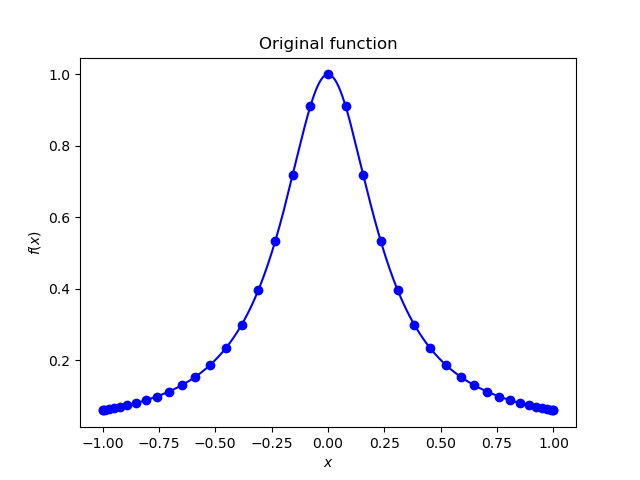

In [8]:
plt.figure()
plt.plot(xGL,fGL,'ob')
plt.plot(xGL_fine,fGL_fine,'-b')
plt.xlabel('$x$')
plt.ylabel("$f(x)$")
plt.title('Original function')
plt.show()

### 3. Derivative

In [9]:
dfGL_fine=fp(xGL_fine)
dfGL=fp(xGL)

In [10]:
D=chebdif(N+1,1) #D[0,:,:]=D, D[1,:,:]=D^2, ...

# either of the two formulations gives the same:
#fp_cheb=np.dot(D[0,:,:],fGL)

fp_cheb=D[0,:,:]@fGL

<IPython.core.display.Javascript object>


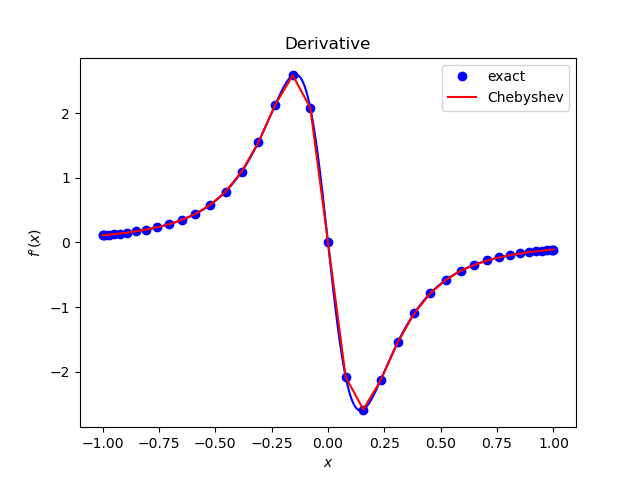

In [11]:
plt.figure()
plt.plot(xGL,dfGL,'ob',label='exact')
plt.plot(xGL_fine,dfGL_fine,'-b')
plt.plot(xGL,fp_cheb,'r',label='Chebyshev')
plt.xlabel('$x$')
plt.ylabel("$f'(x)$")
plt.legend()
plt.title('Derivative')
plt.show()

### 4. Integration

In [12]:
N=15
xGL=GLC_pts(N)
D=chebdif(N+1,1)
D=D[0,:,:]
D[0,:]=np.eye(N+1)[0,:]
Dinv=np.linalg.inv(D)

In [13]:
ff = lambda x: np.cos(x*np.pi/2)**6
fGL=ff(xGL)

<IPython.core.display.Javascript object>


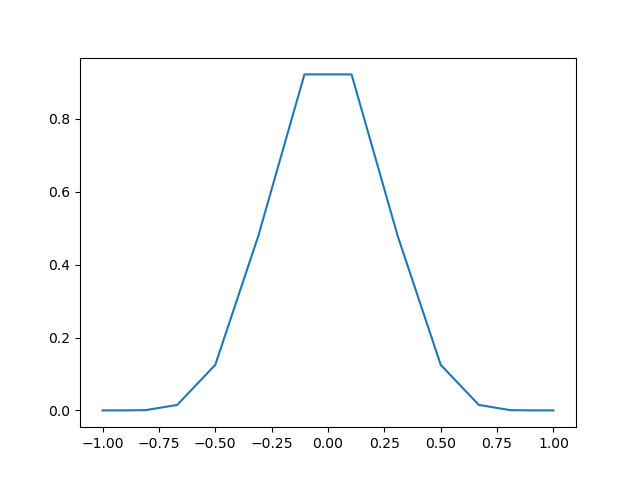

0.6249999149211803

In [14]:
fint = Dinv@fGL
plt.figure()
plt.plot(xGL,fGL)
fint[0]-fint[-1]

In [15]:
# the correct result should be 0.625

w=GLC_pwts(N+1)
np.sum(w[1]*fGL)

0.6249999149211798

In [16]:
np.trapz(np.flip(fGL),np.flip(xGL))

0.6204407497407941

In [17]:
cc = np.zeros((12,4))
for k in np.arange(12):
    N=2**k
    cc[k,0] = N
    xGL=GLC_pts(N)
    fGL=ff(xGL)
    w=GLC_pwts(N+1)
    cc[k,1] = np.sqrt((np.sum(w[1]*fGL)-0.625)**2)
    cc[k,2] = np.sqrt((np.trapz(np.flip(fGL),np.flip(xGL))-0.625)**2)
    
    
    D=chebdif(N+1,1)
    D=D[0,:,:]
    D[0,:]=np.eye(N+1)[0,:]
    Dinv=np.linalg.inv(D)
    fint = Dinv@fGL
    cc[k,3] = np.sqrt((fint[0]-fint[-1]-0.625)**2)

<IPython.core.display.Javascript object>


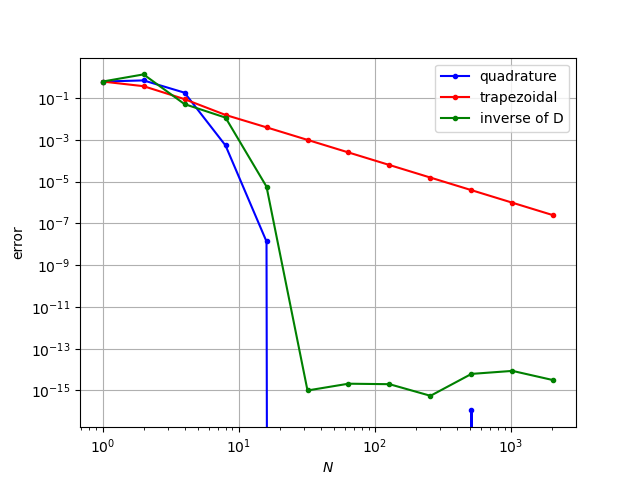

In [18]:
plt.figure()
plt.loglog(cc[:,0],cc[:,1],'b.-',label='quadrature')
plt.loglog(cc[:,0],cc[:,2],'r.-',label='trapezoidal')
plt.loglog(cc[:,0],cc[:,3],'g.-',label='inverse of D')
plt.grid()
plt.xlabel(r'$N$')
plt.ylabel(r'error')
plt.legend()
plt.show()

### 5. Condition number

<IPython.core.display.Javascript object>


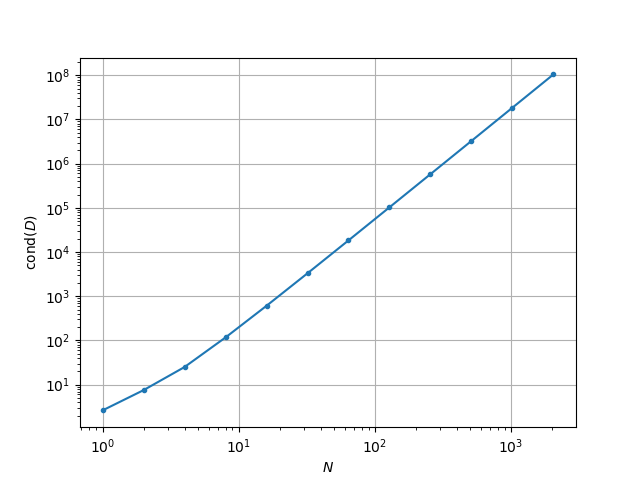

In [19]:
cc=np.zeros((12,2))
for k in np.arange(12):
    N=2**k
    D=chebdif(N+1,1)
    D=D[0,:,:]
    D[0,:]=np.eye(N+1)[0,:]
    cc[k,0] = N
    cc[k,1] = np.linalg.cond(D)
plt.figure()
plt.loglog(cc[:,0],cc[:,1],'.-')
plt.grid()
plt.xlabel(r'$N$')
plt.ylabel(r'$\mathrm{cond}(D)$')
plt.show()